# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *


In [2]:
project_id = "SUSY"
path_to_compiled_data = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/{project_id}"

    
if project_id == "SUSY":
    codes_list = ["BSM_HAA", "SM_SIM"]
    sim_id = "SM_SIM"
    signal_id = "BSM_HAA"

    
uncut_data = {}
for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        uncut_data[code] = pickle.load(ifile)
        
        
    
    print(code, uncut_data[code][list(uncut_data[code].keys())[0]].shape)

BSM_HAA (386943,)
SM_SIM (8783807,)


## Visualize the data

['dijet_pt', 'dijet_eta', 'dijet_mass', 'jet0_btag', 'jet1_btag', 'higgs_pt', 'higgs_eta', 'higgs_mass', 'dimu_pt', 'dimu_eta', 'dimu_mass']


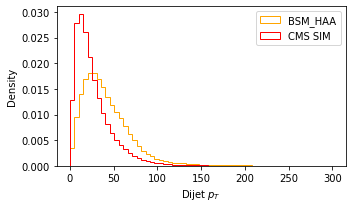

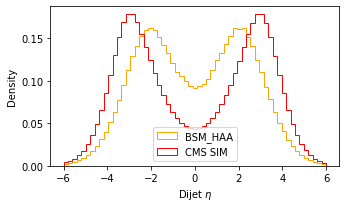

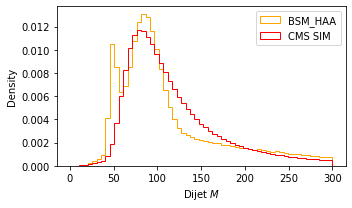

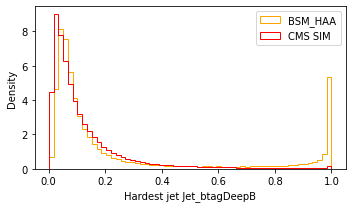

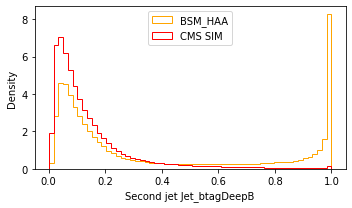

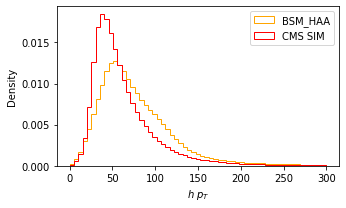

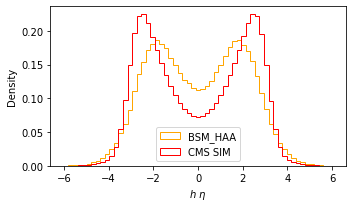

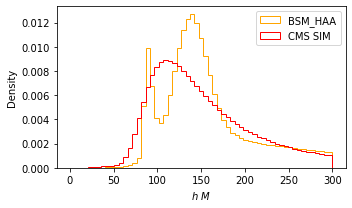

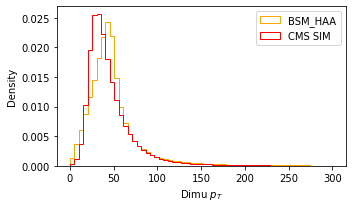

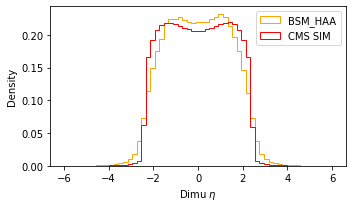

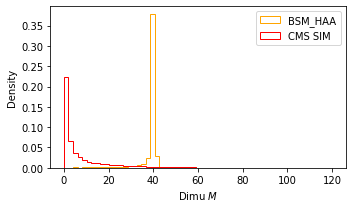

In [3]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype)
    


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [4]:
# jet_cuts

jet_pt_cut = 0 
jet_eta_cut = 10000

btag_cut = 0.0


cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code]["dijet_pt"] > jet_pt_cut) & (np.abs(uncut_data[code]["dijet_eta"]) < jet_eta_cut) & (uncut_data[code]["jet0_btag"] >= btag_cut) & (uncut_data[code]["jet1_btag"] >= btag_cut) 
    cut_data[code] = {}
    
    
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    
    print(f"{code} has shape {cut_data[code][feat].shape} after cuts")
    

BSM_HAA has shape (228318,) after cuts
SM_SIM has shape (6424517,) after cuts


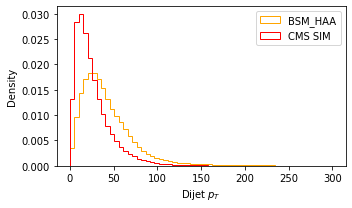

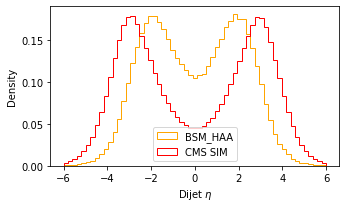

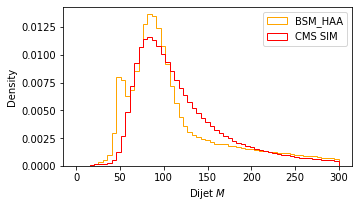

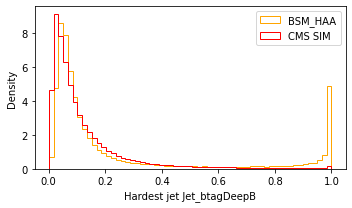

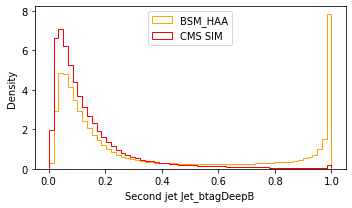

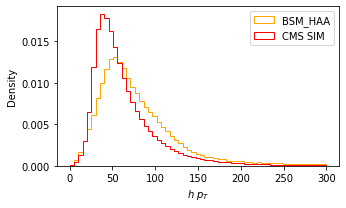

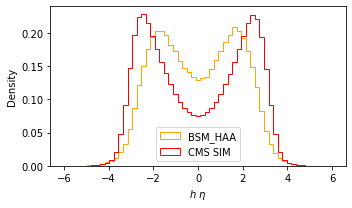

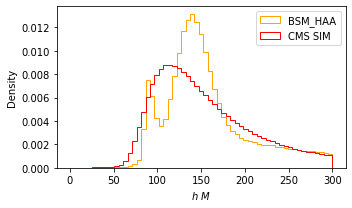

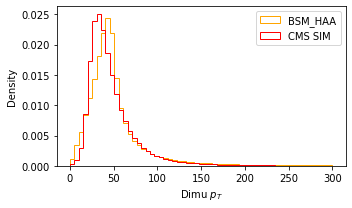

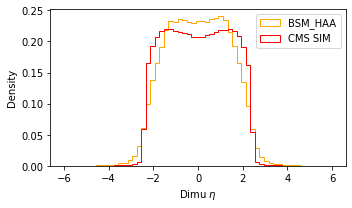

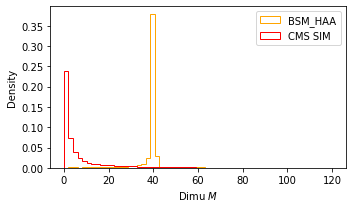

In [5]:
    
    
hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [6]:

#nano
band_bounds = {"SBL": [15, 33],
               "IBL": [33, 35],
               "SR": [35, 45],
               "IBH": [45, 47],
               "SBH": [47, 100],
                       }
"""

# ed
band_bounds = {"SBL": [15, 35],
               "IBL": [35, 40],
               "SR": [40, 60],
               "IBH": [60, 65],
               "SBH": [65, 80],
                       }
"""

'\n\n# ed\nband_bounds = {"SBL": [15, 35],\n               "IBL": [35, 40],\n               "SR": [40, 60],\n               "IBH": [60, 65],\n               "SBH": [65, 80],\n                       }\n'

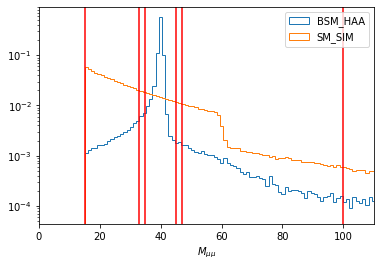

In [7]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code]["dimu_mass"], bins = np.linspace(15, 120, 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(0, 110)
plt.yscale("log")
plt.show()

In [8]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        
        preproc_dicts[b][code] = {}
    

        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]

        

        print(f"{code} {b} has shape {preproc_dicts[b][code][feat].shape}")
        
    print()
   
    
    

BSM_HAA SBL has shape (9777,)
BSM_HAA IBL has shape (2944,)
BSM_HAA SR has shape (203725,)
BSM_HAA IBH has shape (794,)
BSM_HAA SBH has shape (6222,)

SM_SIM SBL has shape (605222,)
SM_SIM IBL has shape (36644,)
SM_SIM SR has shape (140891,)
SM_SIM IBH has shape (21685,)
SM_SIM SBH has shape (144394,)



In [9]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Signal injection


In [10]:
N_bkg_SR_total = preproc_dicts["SR"][sim_id]["dimu_mass"].shape[0]
N_sig_SR_total = preproc_dicts["SR"][signal_id]["dimu_mass"].shape[0]

print(f"{N_bkg_SR_total} bkg in SR, {N_sig_SR_total} sig in SR")


140891 bkg in SR, 203725 sig in SR


In [11]:
# set aside some events for testing (also for full sup)
N_bkg_SR_test = 120000
N_sig_SR_test = 120000

N_bkg_SR_train = N_bkg_SR_total - N_bkg_SR_test
N_sig_SR_train = N_sig_SR_total - N_sig_SR_test

print(N_bkg_SR_train, N_sig_SR_train)

r_bkg = N_bkg_SR_train/N_bkg_SR_total

print("N_bkg_SR_train/N_bkg_SR_total", r_bkg)


20891 83725
N_bkg_SR_train/N_bkg_SR_total 0.148277746626825


Because we set aside some events for a test set, the SR now effectively contains a reduced number of background events, as scaled by `r_bkg`.

If there were no test set, we would:

- Inject a certain number of events `N_sig_inject_SR` into the SR, calculated from the desired significance
- Calculate what fraction of the total number of signal events this represents, `N_sig_inject_SR/N_sig_SR_total`
- Inject this same fraction of the sig events we have in each band into the bkg in each band.

However, we must scale this fraction up by `r_bkg` to reflect the fact that we've removed some bkg events in the SR only

In [12]:
# calculate how many signal events to inject into the SR
desired_significance = 3
N_sig_inject_SR = int(np.sqrt(N_bkg_SR_train)*desired_significance)

frac_sig_to_inject_nonSR = N_sig_inject_SR/(N_sig_SR_total*r_bkg)
print(f"Frac inject in SR:", N_sig_inject_SR/(N_sig_SR_total), "frac inject out of SR:", frac_sig_to_inject_nonSR)

print(f"Attempting to inject {N_sig_inject_SR} events into the SR.")
print(f"Available signal event pool: {N_sig_SR_train}.")

print(f"Desired significance in SR: {desired_significance}, S/B in SR: {N_sig_inject_SR/N_bkg_SR_train}.")


Frac inject in SR: 0.002125414161246779 frac inject out of SR: 0.014334006346858452
Attempting to inject 433 events into the SR.
Available signal event pool: 83725.
Desired significance in SR: 3, S/B in SR: 0.02072662869178115.


In [13]:
num_signal_events_to_inject = {}

for b in bands:
    if b == "SR": 
        num_signal_events_to_inject[b] = N_sig_inject_SR
        #print(int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_model].shape[0]))
    else:
        num_signal_events_to_inject[b] = int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_id]["dimu_mass"].shape[0])
    print(b, num_signal_events_to_inject[b])

SBL 140
IBL 42
SR 433
IBH 11
SBH 89


In [14]:
# then do the injection

from sklearn.utils import shuffle

preproc_dicts_s_inj = {}

for b in bands:
    
    band_data_dict = {}
    
    
    if b == "SR": 
        sig_events_to_inject_inds = np.random.choice(range(N_sig_SR_test, N_sig_SR_test+N_sig_SR_train), size=num_signal_events_to_inject[b], replace=False)
        
        for feat in feature_set:
            sig_events_to_inject = preproc_dicts[b][signal_id][feat][sig_events_to_inject_inds]
            band_data_dict[feat] = np.hstack((preproc_dicts[b][sim_id][feat][N_bkg_SR_test:], sig_events_to_inject))
            
            
    else:
        sig_events_to_inject_inds = np.random.choice(range(preproc_dicts[b][signal_id]["dimu_mass"].shape[0]), size=num_signal_events_to_inject[b], replace=False)
        
        for feat in feature_set:
            sig_events_to_inject = preproc_dicts[b][signal_id][feat][sig_events_to_inject_inds]
            
            band_data_dict[feat] = np.hstack((preproc_dicts[b][sim_id][feat], sig_events_to_inject))
        
    preproc_dicts_s_inj[b] = band_data_dict
    
# test sets
test_sets = {"bkg":{}, "sig":{}}

for feat in feature_set:
    test_sets["bkg"][feat] = preproc_dicts["SR"][sim_id][feat][:N_bkg_SR_test]
    test_sets["sig"][feat] = preproc_dicts["SR"][signal_id][feat][:N_sig_SR_test]

print(test_sets["bkg"])


{'dijet_pt': array([12.62834729,  7.35610872,  6.82402461, ..., 37.95103495,
        2.69793192, 15.80083271]), 'dijet_eta': array([ 4.75855837,  2.56076666,  2.9150773 , ..., -1.36919308,
        5.29680903, -2.49099918]), 'dijet_mass': array([156.2545915 ,  65.19350351, 100.77690656, ..., 294.00960095,
        96.16279319, 184.2261805 ]), 'jet0_btag': array([0.03768921, 0.18676758, 0.30688477, ..., 0.01768494, 0.20129395,
       0.08435059]), 'jet1_btag': array([0.09967041, 0.17431641, 0.01893616, ..., 0.02954102, 0.07672119,
       0.17822266]), 'higgs_pt': array([76.61194386, 37.23685612, 18.56041581, ..., 96.47333602,
        7.10085901, 15.27489118]), 'higgs_eta': array([ 3.31660267,  1.92378545,  2.09284747, ..., -0.98499631,
        4.69289992, -2.62782883]), 'higgs_mass': array([220.40049888, 113.67226356, 144.33874304, ..., 419.90906212,
       137.02223013, 226.5939069 ]), 'dimu_pt': array([ 66.89662717,  29.8810922 ,  15.74188195, ..., 127.55978331,
         6.23151453,  12

## Preprocessing

Standard scaling is fine

In [15]:
save_scaler = True


In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


proc_dict_s_inj = {b:{"s_inj_data":{}} for b in bands}


#if save_scaler:

for feat in feature_set: # also could scale everythign together - same results, but maybe more efficient
    
    SB_all = np.hstack((preproc_dicts_s_inj["SBL"][feat], preproc_dicts_s_inj["SBH"][feat])).reshape(-1, 1)
    loc_feat_scaler = StandardScaler()
    loc_feat_scaler = loc_feat_scaler.fit(SB_all)
    
    
    for b in bands:
        proc_dict_s_inj[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts_s_inj[b][feat].reshape(-1, 1))
        if "eta" not in feat:
             proc_dict_s_inj[b]["s_inj_data"][feat] = (proc_dict_s_inj[b]["s_inj_data"][feat]-7)/2

    # test sets
    for key in test_sets.keys():
        test_sets[key][feat] = loc_feat_scaler.transform(test_sets[key][feat].reshape(-1, 1))
        if "eta" not in feat:
            test_sets[key][feat] = (test_sets[key][feat]-7)/2

"""
    with open(f"processed_data/scaler_{project_id}", "wb") as ofile:
        pickle.dump(scaler, ofile)
else:
    with open(f"processed_data/scaler_{project_id}", "rb") as ifile:
        scaler = pickle.load(ifile)
"""
    


'\n    with open(f"processed_data/scaler_{project_id}", "wb") as ofile:\n        pickle.dump(scaler, ofile)\nelse:\n    with open(f"processed_data/scaler_{project_id}", "rb") as ifile:\n        scaler = pickle.load(ifile)\n'

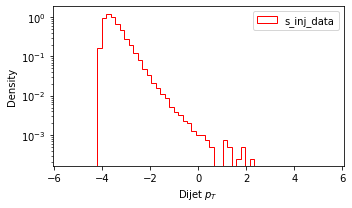

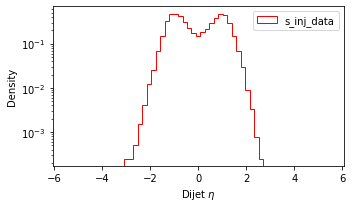

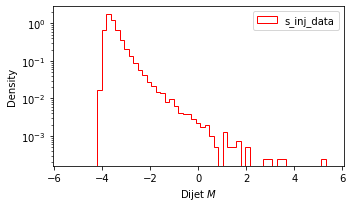

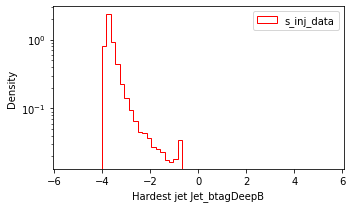

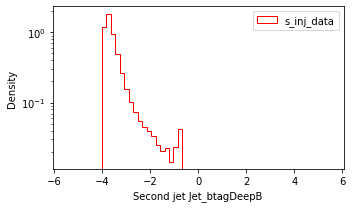

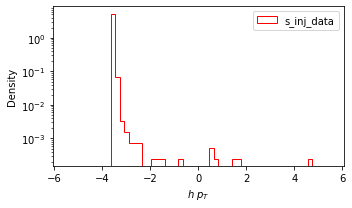

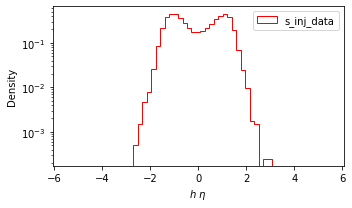

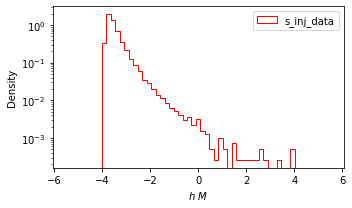

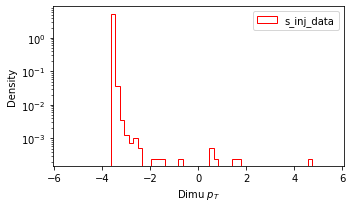

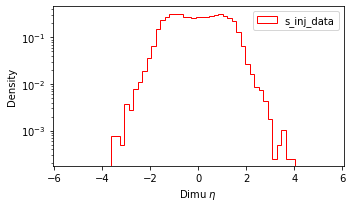

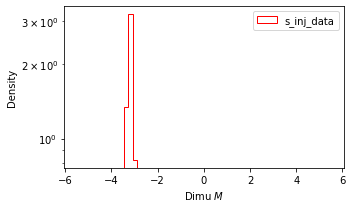

In [17]:
hist_all_features(["s_inj_data"], proc_dict_s_inj["SR"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


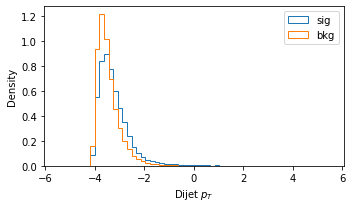

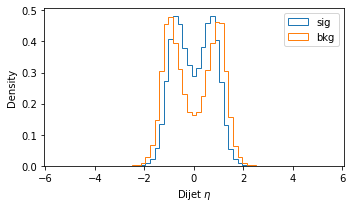

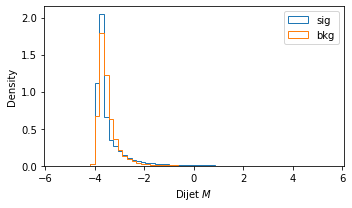

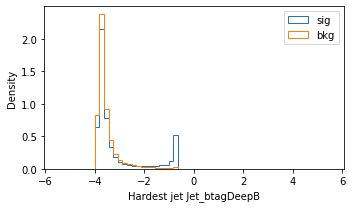

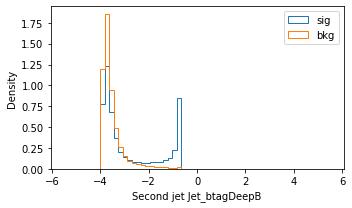

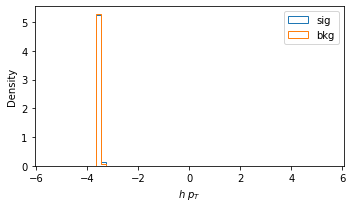

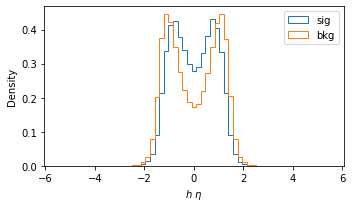

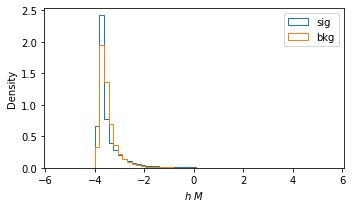

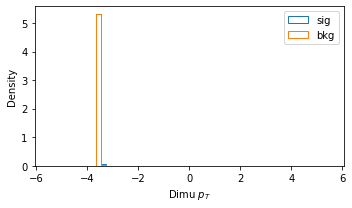

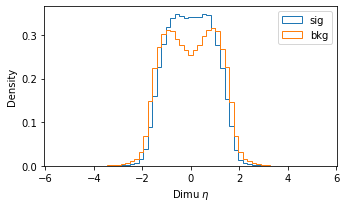

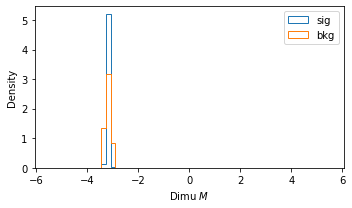

In [18]:
hist_all_features(["sig", "bkg"], test_sets, feature_set, {"sig":{"histtype":"step", "density":True, "label":"sig"}, "bkg":{"histtype":"step", "density":True, "label":"bkg"}}, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = False)


In [19]:
with open(f"processed_data/{project_id}_band_data", "wb") as ofile:
    pickle.dump(proc_dict_s_inj, ofile)
        


N_bkg_SR_fullsup = 110000
N_sig_SR_fullsup = 110000

full_sup_proc, test_proc = {"sig":{}, "bkg":{}}, {"sig":{}, "bkg":{}}

for feat in feature_set:
    full_sup_proc["sig"][feat] = test_sets["sig"][feat][:N_sig_SR_fullsup]
    full_sup_proc["bkg"][feat] = test_sets["bkg"][feat][:N_bkg_SR_fullsup]
    test_proc["sig"][feat] = test_sets["sig"][feat][N_sig_SR_fullsup:]
    test_proc["bkg"][feat] = test_sets["bkg"][feat][N_bkg_SR_fullsup:]
    
    
with open(f"processed_data/{project_id}_fullsup", "wb") as ofile:
    pickle.dump(full_sup_proc, ofile)
    
with open(f"processed_data/{project_id}_test", "wb") as ofile:
    pickle.dump(test_proc, ofile)

print( test_sets["sig"]["dimu_mass"][:N_sig_SR_fullsup].shape, test_sets["bkg"]["dimu_mass"][:N_bkg_SR_fullsup].shape)
print( test_sets["sig"]["dimu_mass"][N_sig_SR_fullsup:].shape, test_sets["bkg"]["dimu_mass"][N_bkg_SR_fullsup:].shape)

(110000, 1) (110000, 1)
(10000, 1) (10000, 1)


In [ ]:
"""
LOAD IN DATA
"""

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = ["dimu_pt", "dimu_mass"]
print(feature_set)
num_features = len(feature_set) - 1 # context doesn't count


with open(f"/global/homes/r/rmastand/dimuonAD/processed_data/{project_id}_band_data", "rb") as ifile:
    proc_dict_s_inj = pickle.load(ifile)
    


for b in bands:
    
    num_events = proc_dict_s_inj[b]["s_inj_data"]["dimu_mass"].shape[0]
    print(b, num_events)
    
    data_dict[b] = np.empty((num_events, num_features+1))
    
    for i, feat in enumerate(feature_set):
    

        data_dict[b][:,i] = proc_dict_s_inj[b]["s_inj_data"][feat].reshape(-1,)



    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))

    


